# Imports

In [356]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

In [4]:
from EntropyCodec import *

## Helpers

In [387]:
def PSNR_RGB(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    mse = torch.mean(torch.square(y_pred - y_true))
    if mse == 0:
        return float('inf')  # consistent handling of zero MSE
    return (10 * torch.log10(max_pixel ** 2 / mse)).item()

# Data

In [5]:
class ImageDataset(Dataset):
    def __init__(self, foldername, transform=None):
        self.file_paths = [os.path.join(foldername, f) for f in os.listdir(foldername) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img = Image.open(self.file_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [311]:
test_path = './test/'
train_path = './train/'
batch_size = 64

train_dataset = ImageDataset(train_path, transform=transform)
test_dataset = ImageDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modeling

## Debug Helpers 

In [56]:
def conv_out(h_in, kernel_size, padding, stride, dilation, output_padding):
    h_out = (h_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
    print(h_out)


def transpose_conv_out(h_in, kernel_size, padding, stride, dilation, output_padding):
    h_out = (
        (h_in - 1) * stride
        - 2 * padding
        + dilation * (kernel_size - 1)
        + output_padding
        + 1
    )
    print(h_out)

In [63]:
def conv_out(h_in, kernel_size, padding, stride, dilation):
    h_out = (h_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
    print(int(h_out))

def transpose_conv_out(h_in, kernel_size, padding, stride, dilation, output_padding):
    h_out = (
        (h_in - 1) * stride
        - 2 * padding
        + dilation * (kernel_size - 1)
        + output_padding
        + 1
    )
    print(int(h_out))


In [69]:
conv_out(h_in=128, kernel_size=7, padding=3, stride=1, dilation=1)
conv_out(h_in=64, kernel_size=5, padding=2, stride=1, dilation=1)
conv_out(h_in=32, kernel_size=3, padding=1, stride=1, dilation=1)
print()
transpose_conv_out(16, kernel_size=3, padding=1, stride=2, dilation=1, output_padding=1)
transpose_conv_out(32, kernel_size=5, padding=2, stride=2, dilation=1, output_padding=1)
transpose_conv_out(64, kernel_size=7, padding=3, stride=2, dilation=1, output_padding=1)

128
64
32

32
64
128


## BaseModel

In [84]:
class BaseAutoEncoder(nn.Module):
    def __init__(self):
        super(BaseAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                16, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 128, kernel_size=5, stride=2, padding=2, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                128, 3, kernel_size=7, stride=2, padding=3, output_padding=1
            ),
            nn.Sigmoid(),
        )

    def forward(self, x, b_t=None):
        x = self.encoder(x)
        if self.training and b_t is not None:
            max_val = x.max() / (2 ** (b_t + 1))
            noise = torch.rand_like(x) * max_val
            x = x + noise
        x = self.decoder(x)
        return x

## Training

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BaseAutoEncoder()

In [289]:
# Параметры изображений
w, h = 128, 128

epochs = 5

NumImagesToShow = 5
b = 3
bt = 3

In [ ]:
model.eval()

In [290]:
def EntropyEncoder(enc_img, size_z, size_h, size_w):
    temp = enc_img.astype(np.uint8).copy()

    maxbinsize = size_h * size_w * size_z
    bitstream = np.zeros(maxbinsize, np.uint8)
    StreamSize = np.zeros(1, np.int32)
    HiddenLayersEncoder(temp, size_w, size_h, size_z, bitstream, StreamSize)
    return bitstream[: StreamSize[0]]


def EntropyDecoder(bitstream, size_z, size_h, size_w):
    decoded_data = np.zeros((size_z, size_h, size_w), np.uint8)
    FrameOffset = np.zeros(1, np.int32)
    HiddenLayersDecoder(decoded_data, size_w, size_h, size_z, bitstream, FrameOffset)
    return decoded_data

In [398]:
def process_images(test_loader, model, device, b, w, h):
    imgs_encoded = []
    imgs_decoded = []

    with torch.no_grad():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            encoded_images = model.encoder(test_batch)
            decoded_images = model.decoder(encoded_images)

            imgs_encoded.append(encoded_images.cpu().detach())
            imgs_decoded.append(decoded_images.cpu().detach())

    imgs_encoded = torch.vstack(imgs_encoded)
    imgs_decoded = torch.vstack(imgs_decoded)


    max_encoded_imgs = imgs_encoded.amax(dim=1, keepdim=True)
    # Normalize and quantize
    norm_imgs_encoded = imgs_encoded / max_encoded_imgs
    quantized_imgs_encoded = (torch.clip(norm_imgs_encoded, 0, 0.9999999) * pow(2, b)).to(
        torch.int32
    )
    quantized_imgs_encoded = quantized_imgs_encoded.numpy()

    # Encode and decode using entropy coding
    quantized_imgs_decoded = []
    bpp = []

    for i in range(quantized_imgs_encoded.shape[0]):
        size_z, size_h, size_w = quantized_imgs_encoded[i].shape
        encoded_bits = EntropyEncoder(quantized_imgs_encoded[i], size_z, size_h, size_w)
        byte_size = len(encoded_bits)
        bpp.append(byte_size * 8 / (w * h))
        quantized_imgs_decoded.append(EntropyDecoder(encoded_bits, size_z, size_h, size_w))
    quantized_imgs_decoded = torch.tensor(np.array(quantized_imgs_decoded, dtype=np.uint8))

    shift = 1.0 / pow(2, b + 1)
    dequantized_imgs_decoded = (quantized_imgs_decoded.to(torch.float32) / pow(2, b)) + shift
    dequantized_denorm_imgs_decoded = dequantized_imgs_decoded * max_encoded_imgs

    imgsQ_decoded = []

    with torch.no_grad():
        for deq_img in dequantized_denorm_imgs_decoded:
            deq_img = deq_img.to(device)
            decoded_imgQ = model.decoder(deq_img)

            imgsQ_decoded.append(decoded_imgQ.cpu().detach())

    imgsQ_decoded = torch.stack(imgsQ_decoded)

    assert imgsQ_decoded.shape == imgs_decoded.shape
    assert imgsQ_decoded.shape[0] == len(bpp)

    return imgs_decoded, imgsQ_decoded, bpp

In [400]:
imgs_decoded, imgsQ_decoded, bpp = process_images(test_loader, model, device, b, w, h)

In [401]:
to_pil_transform = transforms.ToPILImage()

def JPEGRDSingleImage(torch_img, TargetBPP):
    image = to_pil_transform(torch_img)

    width, height = image.size
    realbpp = 0
    realpsnr = 0
    realQ = 0
    for Q in range(101):
        image.save("test.jpeg", "JPEG", quality=Q)
        image_dec = Image.open("test.jpeg")
        bytesize = os.path.getsize("test.jpeg")
        bpp = bytesize * 8 / (width * height)
        psnr = PSNR_RGB(np.array(image), np.array(image_dec))
        if abs(realbpp - TargetBPP) > abs(bpp - TargetBPP):
            realbpp = bpp
            realpsnr = psnr
            realQ = Q
    return image, realQ, realbpp, realpsnr

In [406]:
def display_images_and_save_pdf(test_dataset, imgs_decoded, imgsQ_decoded, bpp, filepath, NumImagesToShow=None):
    if NumImagesToShow is None:
        NumImagesToShow = len(test_dataset)
    cols = NumImagesToShow
    rows = 4

    fig = plt.figure(figsize=(2 * cols, 2 * rows))

    for i in range(NumImagesToShow):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(to_pil_transform(test_dataset[i]), interpolation="nearest")
        plt.title("", fontsize=10)
        plt.axis('off')
    
    for i in range(NumImagesToShow):
        psnr = PSNR(test_dataset[i], imgs_decoded[i])
        plt.subplot(rows, cols, cols + i + 1)
        plt.imshow(to_pil_transform(imgs_decoded[i]), interpolation="nearest")
        plt.title(f"PSNR: {psnr:.2f}", fontsize=10)
        plt.axis('off')
    
    for i in range(NumImagesToShow):
        psnr = PSNR(test_dataset[i], imgsQ_decoded[i])
        plt.subplot(rows, cols, 2 * cols + i + 1)
        plt.imshow(to_pil_transform(imgsQ_decoded[i]), interpolation="nearest")
        plt.title(f"PSNR: {psnr:.2f} | BPP: {bpp[i]:.2f}", fontsize=10)
        plt.axis('off')
    

    for i in range(NumImagesToShow):
        jpeg_img, JPEGQP, JPEGrealbpp, JPEGrealpsnr = JPEGRDSingleImage(test_dataset[i], bpp[i])
        plt.subplot(rows, cols, 3 * cols + i + 1)
        plt.imshow(jpeg_img, interpolation="nearest")
        plt.title(f"PSNR: {JPEGrealpsnr:.2f} | BPP: {JPEGrealbpp:.2f}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(filepath, format='pdf')
    return fig

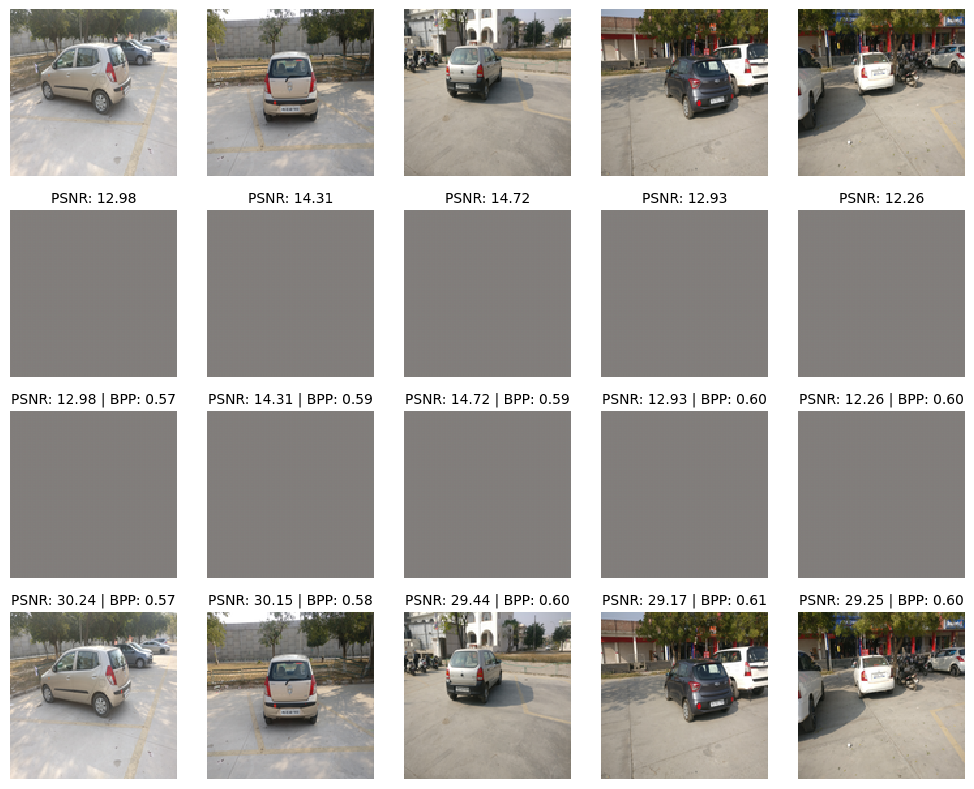

In [407]:
fig = display_images_and_save_pdf(test_dataset, imgs_decoded, imgsQ_decoded, bpp, 'output.pdf', NumImagesToShow=5)

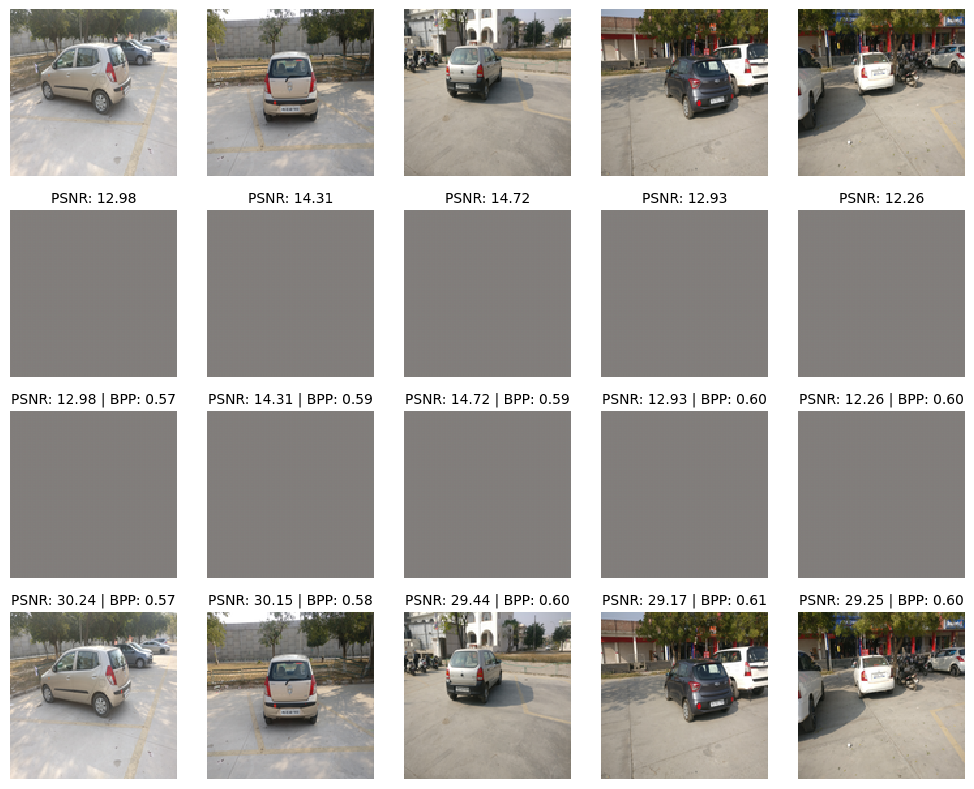

In [408]:
fig